# NCAAM Network-Based Team Strength Analysis

## Objective
Implement network-based strength propagation for team tier classification:
- **Iterative Strength Ratings**: Massey/PageRank-style algorithm
- **Network-Weighted SOS**: Strength of schedule using network ratings
- **Multi-Hop Common Opponents**: 3-level transitive relationships

## NCAAM-Specific Characteristics
- 350+ teams, ~30-game season per team
- **Sparse graph** with **conference clusters**
- Cross-conference games create bridges between clusters
- Need deeper path exploration to connect distant teams
- Parameters: `max_hops=3`, `recency_decay=0.85`, `margin_cap=20`

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from datetime import datetime, timedelta
from collections import Counter

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# NCAAM-specific config
CONFIG = {
    'sport': 'NCAAM',
    'max_hops': 3,          # Need deeper paths across conferences
    'recency_decay': 0.85,  # Early season less relevant
    'margin_cap': 20,       # Similar to NFL
    'iterations': 150,      # More iterations for larger network
    'tolerance': 0.0005     # Tighter tolerance for convergence
}

print(f"Config: {CONFIG}")

Config: {'sport': 'NCAAM', 'max_hops': 3, 'recency_decay': 0.85, 'margin_cap': 20, 'iterations': 150, 'tolerance': 0.0005}


## Phase 1: Data Loading & Preparation

In [2]:
# Load NCAAM data
data_file = Path().resolve().parent / 'data' / 'results' / 'ncaam_season_results.xlsx'
df = pd.read_excel(data_file)

print(f"Loaded {len(df)} NCAAM games")
print(f"Date range: {df['game_date'].min().date()} to {df['game_date'].max().date()}")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 2280 NCAAM games
Date range: 2025-11-03 to 2026-01-05
Columns: ['game_date', 'home_team', 'away_team', 'closing_spread', 'home_score', 'away_score', 'spread_result_difference']


,game_date,home_team,away_team,closing_spread,home_score,away_score,spread_result_difference
0,2025-11-03,Colorado Buffaloes,Montana St Bobcats,-12.5,84,78,-6.5
1,2025-11-03,Radford Highlanders,Western Illinois Leathernecks,-16.5,80,75,-11.5
2,2025-11-03,George Mason Patriots,Wofford Terriers,-14.5,70,46,9.5
3,2025-11-03,Baylor Bears,UT Rio Grande Valley Vaqueros,-24.5,96,81,-9.5
4,2025-11-03,Wisconsin Badgers,Campbell Fighting Camels,-20.5,96,64,11.5


In [3]:
# Prepare game-level data
df['home_margin'] = df['home_score'] - df['away_score']
df['winner'] = np.where(df['home_margin'] > 0, df['home_team'], 
                        np.where(df['home_margin'] < 0, df['away_team'], None))
df['loser'] = np.where(df['home_margin'] > 0, df['away_team'], 
                       np.where(df['home_margin'] < 0, df['home_team'], None))
df['margin'] = df['home_margin'].abs()

games_with_result = df[df['winner'].notna()].copy()
print(f"Games with decisive result: {len(games_with_result)}")

# Get all teams
all_teams = set(df['home_team'].unique()) | set(df['away_team'].unique())
print(f"Total teams: {len(all_teams)}")

# Avg games per team
games_per_team = (len(df) * 2) / len(all_teams)
print(f"Avg games per team: {games_per_team:.1f}")

Games with decisive result: 2280
Total teams: 365
Avg games per team: 12.5


## Phase 2: Build Network Graph

NCAAM has a sparse graph with conference clusters. We'll analyze connectivity.

In [4]:
def build_team_network(games_df, recency_decay=0.85):
    """Build weighted directed graph - optimized for sparse NCAAM network."""
    G = nx.DiGraph()
    
    for team in all_teams:
        G.add_node(team)
    
    games_sorted = games_df.sort_values('game_date')
    max_date = games_sorted['game_date'].max()
    
    edge_data = {}
    
    for _, game in games_sorted.iterrows():
        winner, loser = game['winner'], game['loser']
        margin = game['margin']
        
        days_ago = (max_date - game['game_date']).days
        recency_weight = recency_decay ** (days_ago / 7)
        
        key = (winner, loser)
        if key not in edge_data:
            edge_data[key] = {
                'games': 0,
                'total_margin': 0,
                'weighted_margin': 0,
                'total_weight': 0
            }
        
        edge_data[key]['games'] += 1
        edge_data[key]['total_margin'] += margin
        edge_data[key]['weighted_margin'] += margin * recency_weight
        edge_data[key]['total_weight'] += recency_weight
    
    for (winner, loser), data in edge_data.items():
        avg_margin = data['total_margin'] / data['games']
        weighted_avg = data['weighted_margin'] / data['total_weight']
        
        G.add_edge(winner, loser, 
                   games=data['games'],
                   avg_margin=avg_margin,
                   weighted_margin=weighted_avg)
    
    return G

G = build_team_network(games_with_result, CONFIG['recency_decay'])

print(f"Network Summary:")
print(f"  Nodes (teams): {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Avg degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.1f}")
print(f"  Density: {nx.density(G):.4f}")

Network Summary:
  Nodes (teams): 365
  Edges: 2276
  Avg degree: 12.5
  Density: 0.0171


In [5]:
# Analyze graph connectivity - critical for NCAAM
G_undirected = G.to_undirected()

# Find connected components
components = list(nx.connected_components(G_undirected))
print(f"\nConnectivity Analysis:")
print(f"  Connected components: {len(components)}")
print(f"  Largest component: {len(max(components, key=len))} teams")

if len(components) > 1:
    print(f"  Isolated teams: {sum(1 for c in components if len(c) == 1)}")
    small_components = [c for c in components if 1 < len(c) < 10]
    print(f"  Small clusters (2-9 teams): {len(small_components)}")

# Degree distribution
degrees = [d for _, d in G.degree()]
print(f"\nDegree Distribution:")
print(f"  Min: {min(degrees)}, Max: {max(degrees)}, Median: {np.median(degrees):.0f}")

# Low-connectivity teams (potential issues)
low_conn_teams = [n for n, d in G.degree() if d < 5]
print(f"  Teams with <5 connections: {len(low_conn_teams)}")


Connectivity Analysis:
  Connected components: 1
  Largest component: 365 teams

Degree Distribution:
  Min: 8, Max: 17, Median: 13
  Teams with <5 connections: 0


In [6]:
# Detect conference-like clusters using community detection
try:
    from networkx.algorithms.community import louvain_communities
    communities = louvain_communities(G_undirected, seed=42)
    
    print(f"\nCommunity Detection (Conference Proxy):")
    print(f"  Communities found: {len(communities)}")
    
    # Size distribution
    sizes = sorted([len(c) for c in communities], reverse=True)
    print(f"  Largest 10 communities: {sizes[:10]}")
    
    # Store community membership
    team_community = {}
    for i, comm in enumerate(communities):
        for team in comm:
            team_community[team] = i
            
except ImportError:
    print("Community detection not available (needs networkx >= 2.6)")
    team_community = {team: 0 for team in all_teams}


Community Detection (Conference Proxy):
  Communities found: 6
  Largest 10 communities: [97, 81, 67, 49, 36, 35]


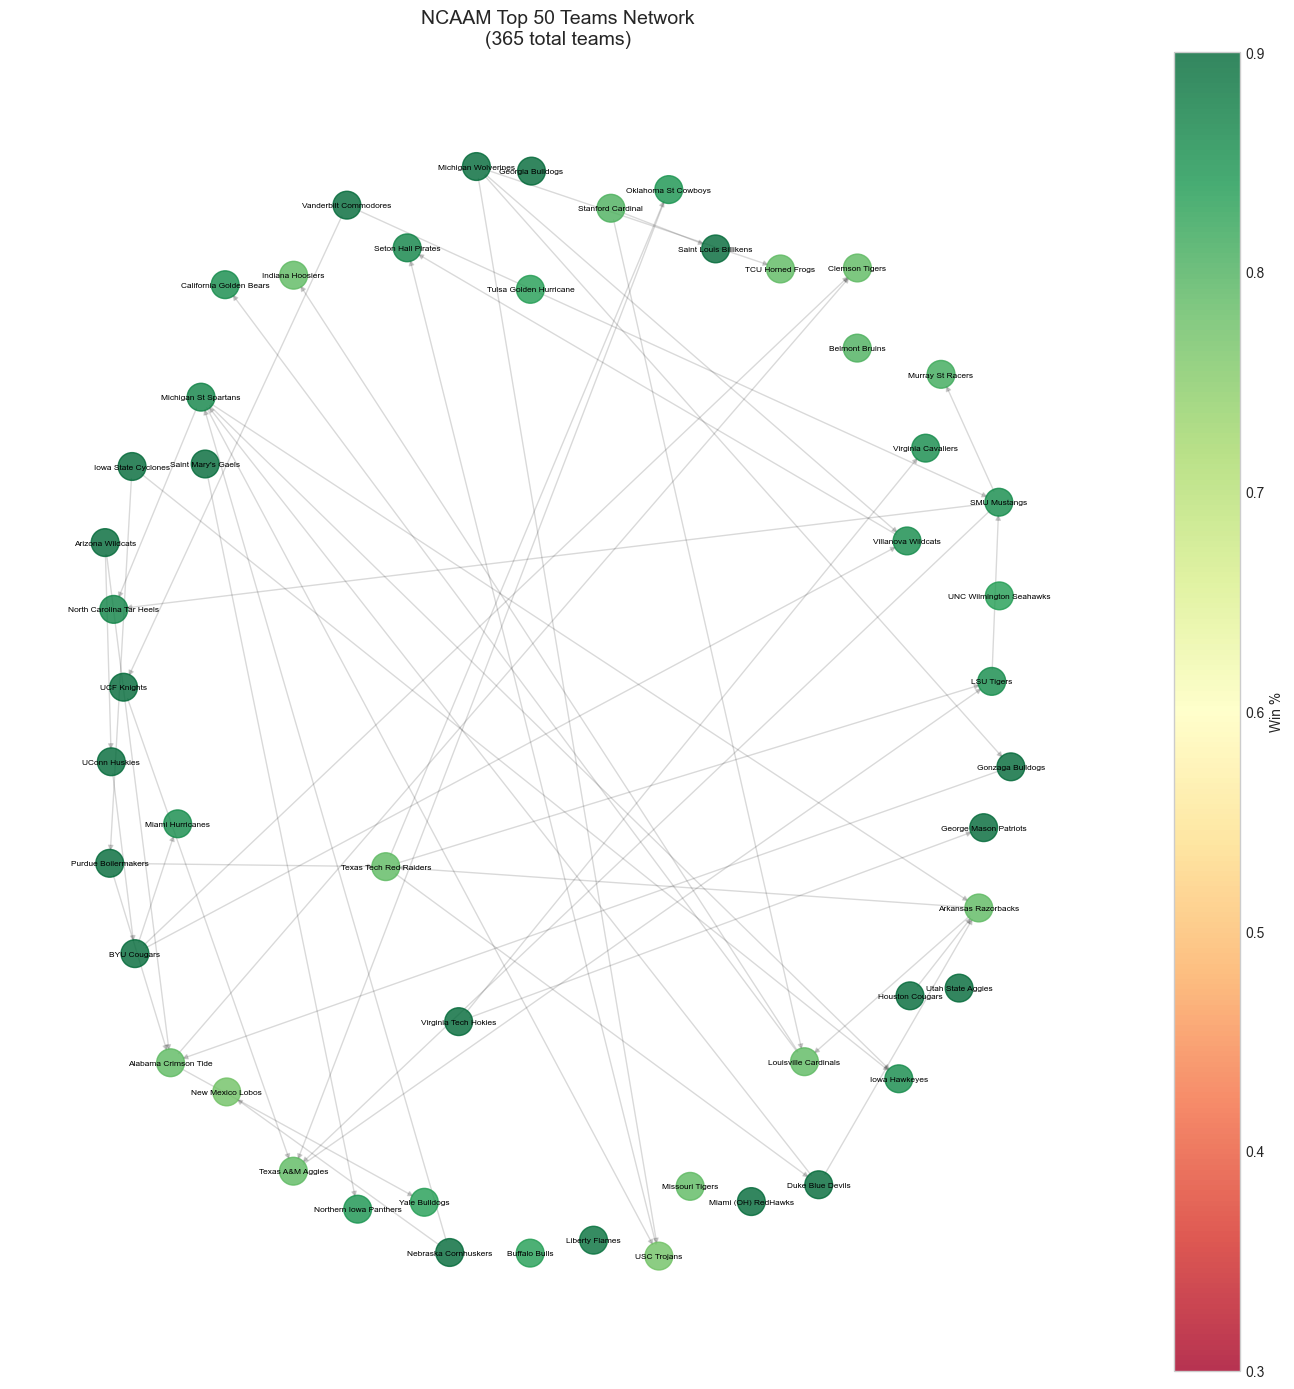

In [7]:
# Visualize (sample of top teams only due to size)
# Calculate simple win% for filtering
win_counts = dict(G.out_degree())
loss_counts = dict(G.in_degree())
win_pct = {team: win_counts.get(team, 0) / (win_counts.get(team, 0) + loss_counts.get(team, 0) + 0.001)
           for team in all_teams}

# Filter to top 50 teams by win%
top_teams = sorted(win_pct.items(), key=lambda x: -x[1])[:50]
top_team_names = [t[0] for t in top_teams]

G_sub = G.subgraph(top_team_names).copy()

fig, ax = plt.subplots(figsize=(14, 14))

node_colors = [win_pct.get(node, 0.5) for node in G_sub.nodes()]
pos = nx.spring_layout(G_sub, k=2, iterations=50, seed=42)

nodes = nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, cmap=plt.cm.RdYlGn,
                               node_size=400, alpha=0.8, vmin=0.3, vmax=0.9, ax=ax)
nx.draw_networkx_labels(G_sub, pos, font_size=6, ax=ax)
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, arrows=True, arrowsize=8, ax=ax)

ax.set_title(f'NCAAM Top 50 Teams Network\n({G.number_of_nodes()} total teams)', fontsize=14)
fig.colorbar(nodes, ax=ax, label='Win %')
ax.axis('off')
plt.tight_layout()
plt.show()

## Phase 3: Iterative Strength Rating

For NCAAM's sparse graph, we need more iterations and careful handling of isolated teams.

In [8]:
def compute_iterative_strength(games_df, max_iterations=150, tolerance=0.0005, margin_cap=20):
    """
    Compute network strength ratings - optimized for sparse NCAAM network.
    
    Uses smaller learning rate and more iterations for large sparse graph.
    """
    teams = set(games_df['home_team']) | set(games_df['away_team'])
    ratings = {team: 0.5 for team in teams}
    games = games_df[games_df['winner'].notna()].copy()
    
    # Smaller learning rate for stability with many teams
    learning_rate = 0.03
    
    history = []
    
    for iteration in range(max_iterations):
        new_ratings = ratings.copy()
        
        for _, game in games.iterrows():
            winner = game['winner']
            loser = game['loser']
            margin = min(game['margin'], margin_cap)
            
            winner_rating = ratings[winner]
            loser_rating = ratings[loser]
            
            total = winner_rating + loser_rating
            expected = winner_rating / total if total > 0 else 0.5
            
            surprise = 1 - expected
            adjustment = surprise * (margin / margin_cap) * learning_rate
            
            new_ratings[winner] += adjustment
            new_ratings[loser] -= adjustment
        
        # Normalize
        min_r = min(new_ratings.values())
        max_r = max(new_ratings.values())
        if max_r > min_r:
            new_ratings = {t: (r - min_r) / (max_r - min_r) for t, r in new_ratings.items()}
        
        max_change = max(abs(new_ratings[t] - ratings[t]) for t in teams)
        history.append(max_change)
        
        if max_change < tolerance:
            print(f"Converged at iteration {iteration + 1}")
            break
        
        ratings = new_ratings
    else:
        print(f"Did not converge in {max_iterations} iterations (final change: {max_change:.6f})")
    
    return ratings, history

# Compute ratings
network_ratings, convergence_history = compute_iterative_strength(
    df, 
    max_iterations=CONFIG['iterations'],
    tolerance=CONFIG['tolerance'],
    margin_cap=CONFIG['margin_cap']
)

# Top teams
ratings_df = pd.DataFrame([
    {'team': team, 'network_rating': rating}
    for team, rating in network_ratings.items()
]).sort_values('network_rating', ascending=False)

print("\nTop 15 Teams by Network Rating:")
print(ratings_df.head(15).to_string(index=False))

Did not converge in 150 iterations (final change: 0.029310)

Top 15 Teams by Network Rating:
                 team  network_rating
  Michigan Wolverines        1.000000
     Arizona Wildcats        0.858987
  Purdue Boilermakers        0.824368
     Gonzaga Bulldogs        0.815234
 Michigan St Spartans        0.809173
   Saint Mary's Gaels        0.788784
  Iowa State Cyclones        0.785903
        UConn Huskies        0.783022
          BYU Cougars        0.766563
Vanderbilt Commodores        0.760841
 Nebraska Cornhuskers        0.753765
     Duke Blue Devils        0.730031
Saint Louis Billikens        0.686873
     Georgia Bulldogs        0.685394
   Villanova Wildcats        0.681427


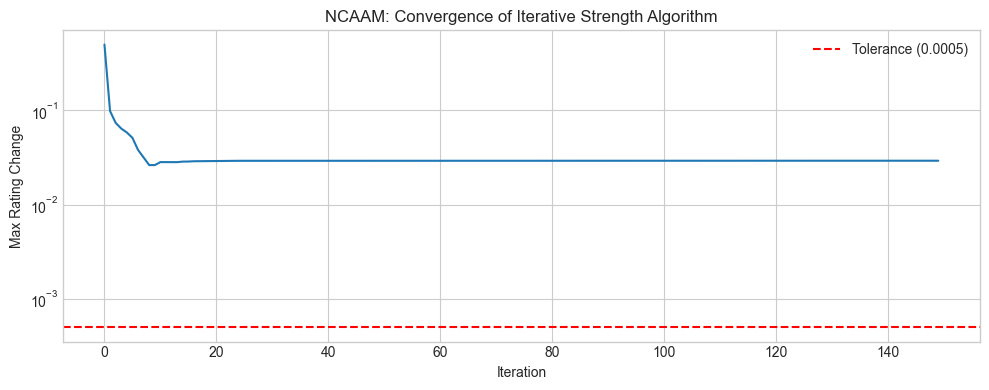

In [9]:
# Plot convergence
plt.figure(figsize=(10, 4))
plt.plot(convergence_history)
plt.axhline(y=CONFIG['tolerance'], color='r', linestyle='--', label=f"Tolerance ({CONFIG['tolerance']})")
plt.xlabel('Iteration')
plt.ylabel('Max Rating Change')
plt.title('NCAAM: Convergence of Iterative Strength Algorithm')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

## Phase 4: Validate Ratings

In [10]:
# Calculate simple team stats
team_stats = []
for team in all_teams:
    home_games = df[df['home_team'] == team]
    away_games = df[df['away_team'] == team]
    
    home_wins = (home_games['home_score'] > home_games['away_score']).sum()
    away_wins = (away_games['away_score'] > away_games['home_score']).sum()
    
    home_diff = (home_games['home_score'] - home_games['away_score']).sum()
    away_diff = (away_games['away_score'] - away_games['home_score']).sum()
    
    total_games = len(home_games) + len(away_games)
    
    opponents = list(home_games['away_team']) + list(away_games['home_team'])
    
    team_stats.append({
        'team': team,
        'games': total_games,
        'wins': home_wins + away_wins,
        'simple_win_pct': (home_wins + away_wins) / total_games if total_games > 0 else 0,
        'point_diff_avg': (home_diff + away_diff) / total_games if total_games > 0 else 0,
        'network_rating': network_ratings.get(team, 0.5),
        'community': team_community.get(team, -1),
        'opponents': opponents
    })

df_teams = pd.DataFrame(team_stats)

# Calculate SOS
win_pct_map = df_teams.set_index('team')['simple_win_pct'].to_dict()
df_teams['simple_sos'] = df_teams['opponents'].apply(
    lambda opps: np.mean([win_pct_map.get(o, 0.5) for o in opps]) if opps else 0.5
)
df_teams['network_sos'] = df_teams['opponents'].apply(
    lambda opps: np.mean([network_ratings.get(o, 0.5) for o in opps]) if opps else 0.5
)

df_teams = df_teams.drop('opponents', axis=1).sort_values('network_rating', ascending=False)
print(f"Team stats calculated for {len(df_teams)} teams")
df_teams.head(10)

Team stats calculated for 365 teams


,team,games,wins,simple_win_pct,point_diff_avg,network_rating,community,simple_sos,network_sos
126,Michigan Wolverines,13,13,1.000000,30.230769,1.000000,1,0.642773,0.383227
250,Arizona Wildcats,14,14,1.000000,23.714286,0.858987,5,0.525392,0.300919
9,Purdue Boilermakers,14,13,0.928571,19.857143,0.824368,3,0.565986,0.350603
273,Gonzaga Bulldogs,17,16,0.941176,24.235294,0.815234,5,0.498613,0.314709
262,Michigan St Spartans,15,13,0.866667,14.666667,0.809173,2,0.604365,0.363333
193,Saint Mary's Gaels,14,13,0.928571,15.857143,0.788784,5,0.549400,0.298974
341,Iowa State Cyclones,13,13,1.000000,26.769231,0.785903,0,0.445424,0.279063
161,UConn Huskies,15,14,0.933333,17.666667,0.783022,4,0.556752,0.351704
329,BYU Cougars,14,13,0.928571,20.000000,0.766563,5,0.583248,0.338551
24,Vanderbilt Commodores,11,11,1.000000,22.636364,0.760841,0,0.498654,0.287362


Teams with 15+ games: 35

Correlation Analysis (teams with 15+ games):
  Network Rating vs Win%: 0.942
  Network Rating vs Point Diff: 0.928
  Network SOS vs Simple SOS: 0.909


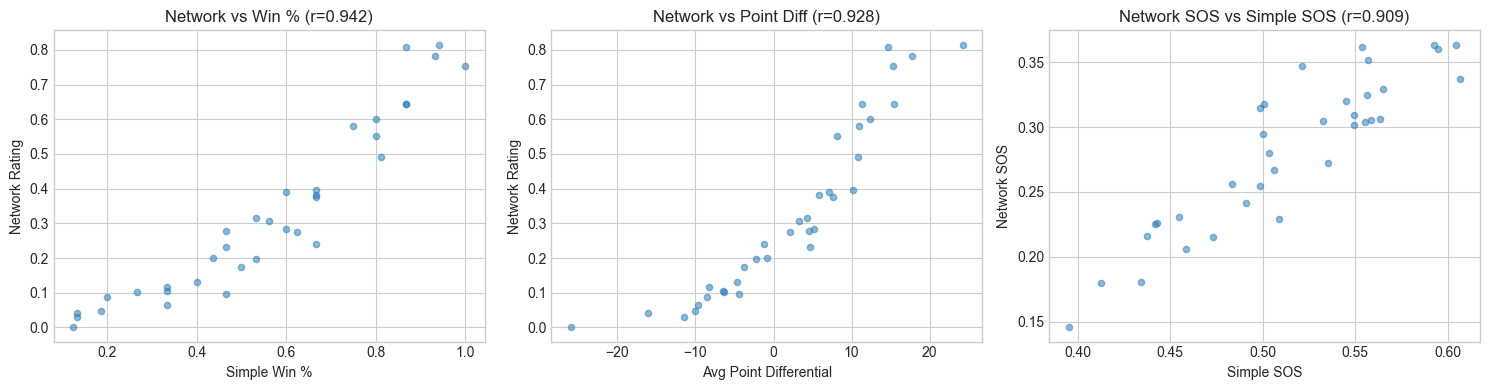

In [11]:
# Correlation analysis
# Filter to teams with enough games for reliable stats
df_reliable = df_teams[df_teams['games'] >= 15].copy()
print(f"Teams with 15+ games: {len(df_reliable)}")

corr_win_pct = df_reliable['network_rating'].corr(df_reliable['simple_win_pct'])
corr_point_diff = df_reliable['network_rating'].corr(df_reliable['point_diff_avg'])
corr_sos = df_reliable['network_sos'].corr(df_reliable['simple_sos'])

print(f"\nCorrelation Analysis (teams with 15+ games):")
print(f"  Network Rating vs Win%: {corr_win_pct:.3f}")
print(f"  Network Rating vs Point Diff: {corr_point_diff:.3f}")
print(f"  Network SOS vs Simple SOS: {corr_sos:.3f}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df_reliable['simple_win_pct'], df_reliable['network_rating'], alpha=0.5, s=20)
axes[0].set_xlabel('Simple Win %')
axes[0].set_ylabel('Network Rating')
axes[0].set_title(f'Network vs Win % (r={corr_win_pct:.3f})')

axes[1].scatter(df_reliable['point_diff_avg'], df_reliable['network_rating'], alpha=0.5, s=20)
axes[1].set_xlabel('Avg Point Differential')
axes[1].set_ylabel('Network Rating')
axes[1].set_title(f'Network vs Point Diff (r={corr_point_diff:.3f})')

axes[2].scatter(df_reliable['simple_sos'], df_reliable['network_sos'], alpha=0.5, s=20)
axes[2].set_xlabel('Simple SOS')
axes[2].set_ylabel('Network SOS')
axes[2].set_title(f'Network SOS vs Simple SOS (r={corr_sos:.3f})')

plt.tight_layout()
plt.show()

## Phase 5: Network-Based Tier Classification

In [12]:
# Classify tiers (using reliable teams only)
q75_simple, q25_simple = df_reliable['simple_win_pct'].quantile([0.75, 0.25])
q75_network, q25_network = df_reliable['network_rating'].quantile([0.75, 0.25])

df_teams['simple_tier'] = df_teams['simple_win_pct'].apply(
    lambda x: 'Elite' if x >= q75_simple else ('Bottom' if x <= q25_simple else 'Mid')
)
df_teams['network_tier'] = df_teams['network_rating'].apply(
    lambda x: 'Elite' if x >= q75_network else ('Bottom' if x <= q25_network else 'Mid')
)

print("Tier Classification:")
print(f"  Simple thresholds: Elite >= {q75_simple:.3f}, Bottom <= {q25_simple:.3f}")
print(f"  Network thresholds: Elite >= {q75_network:.3f}, Bottom <= {q25_network:.3f}")

# Agreement
df_compare = df_teams[df_teams['games'] >= 15]
agreement = pd.crosstab(df_compare['simple_tier'], df_compare['network_tier'], margins=True)
print(f"\nTier Agreement (teams with 15+ games):")
print(agreement)

# Significant disagreements
disagreements = df_compare[
    (df_compare['simple_tier'] == 'Elite') & (df_compare['network_tier'] != 'Elite') |
    (df_compare['simple_tier'] != 'Elite') & (df_compare['network_tier'] == 'Elite')
]
print(f"\nElite tier disagreements ({len(disagreements)}):")
print(disagreements[['team', 'games', 'simple_win_pct', 'network_rating', 
                     'simple_sos', 'network_sos', 'simple_tier', 'network_tier']].head(10).to_string(index=False))

Tier Classification:
  Simple thresholds: Elite >= 0.775, Bottom <= 0.367
  Network thresholds: Elite >= 0.522, Bottom <= 0.110

Tier Agreement (teams with 15+ games):
network_tier  Bottom  Elite  Mid  All
simple_tier                          
Bottom             8      0    1    9
Elite              0      8    1    9
Mid                1      1   15   17
All                9      9   17   35

Elite tier disagreements (2):
               team  games  simple_win_pct  network_rating  simple_sos  network_sos simple_tier network_tier
Santa Clara Broncos     16          0.7500        0.580479    0.535379     0.271995         Mid        Elite
   Murray St Racers     16          0.8125        0.491136    0.441891     0.225111       Elite          Mid


## Phase 6: Multi-Hop Common Opponent Analysis

For NCAAM, multi-hop paths are critical for connecting teams across conferences.

In [13]:
def find_common_opponent_paths(G, team_a, team_b, max_hops=3):
    """Find paths through common opponents - optimized for sparse graphs."""
    G_undirected = G.to_undirected()
    
    if team_a not in G or team_b not in G:
        return []
    
    # Check if teams are in same component
    if not nx.has_path(G_undirected, team_a, team_b):
        return []
    
    paths = []
    try:
        # Limit paths to avoid combinatorial explosion
        path_gen = nx.all_simple_paths(G_undirected, team_a, team_b, cutoff=max_hops + 1)
        for i, path in enumerate(path_gen):
            if len(path) > 2:
                paths.append(path)
            if i > 1000:  # Limit for performance
                break
    except nx.NetworkXNoPath:
        pass
    
    return paths

def evaluate_matchup_via_paths(G, team_a, team_b, ratings, max_hops=3):
    """Evaluate teams through common opponent network."""
    paths = find_common_opponent_paths(G, team_a, team_b, max_hops)
    
    if not paths:
        return None, 0, []
    
    a_total_score = 0
    b_total_score = 0
    total_weight = 0
    path_details = []
    
    for path in paths:
        intermediates = path[1:-1]
        a_path_score = 0
        b_path_score = 0
        path_weight = 0
        
        for intermediate in intermediates:
            int_rating = ratings.get(intermediate, 0.5)
            
            if G.has_edge(team_a, intermediate):
                margin = G[team_a][intermediate].get('avg_margin', 0)
                a_path_score += margin * int_rating
            elif G.has_edge(intermediate, team_a):
                margin = G[intermediate][team_a].get('avg_margin', 0)
                a_path_score -= margin * int_rating
            
            if G.has_edge(team_b, intermediate):
                margin = G[team_b][intermediate].get('avg_margin', 0)
                b_path_score += margin * int_rating
            elif G.has_edge(intermediate, team_b):
                margin = G[intermediate][team_b].get('avg_margin', 0)
                b_path_score -= margin * int_rating
            
            path_weight += int_rating
        
        if path_weight > 0:
            a_total_score += a_path_score
            b_total_score += b_path_score
            total_weight += path_weight
            
            path_details.append({
                'path': ' -> '.join(path),
                'hops': len(path) - 2,
                'a_score': a_path_score / path_weight if path_weight else 0,
                'b_score': b_path_score / path_weight if path_weight else 0
            })
    
    if total_weight == 0:
        return None, 0, []
    
    edge = (a_total_score - b_total_score) / total_weight
    return edge, len(paths), path_details

# Example: Compare top team vs a mid-tier team
top_team = df_teams.iloc[0]['team']
mid_team = df_teams[df_teams['network_tier'] == 'Mid'].iloc[0]['team']

edge, num_paths, details = evaluate_matchup_via_paths(G, top_team, mid_team, network_ratings, CONFIG['max_hops'])

print(f"Matchup Analysis: {top_team} vs {mid_team}")
print(f"Paths found: {num_paths}")
if edge is not None:
    print(f"Common opponent edge: {edge:.2f} ({'favors ' + top_team if edge > 0 else 'favors ' + mid_team})")
    
    if details:
        path_df = pd.DataFrame(details)
        print(f"\nPaths by hop count:")
        print(path_df.groupby('hops').size())
else:
    print("No paths found - teams may be in different components")

Matchup Analysis: Michigan Wolverines vs UC San Diego Tritons
Paths found: 72
Common opponent edge: 15.24 (favors Michigan Wolverines)

Paths by hop count:
hops
2     8
3    64
dtype: int64


In [14]:
# Analyze cross-conference connectivity
# Find paths between teams in different communities

def analyze_cross_conference_paths(G, team_community, ratings, sample_size=20):
    """Analyze path lengths between teams in different communities."""
    results = []
    
    # Sample teams from different communities
    comm_teams = {}
    for team, comm in team_community.items():
        if comm not in comm_teams:
            comm_teams[comm] = []
        comm_teams[comm].append(team)
    
    # Get top teams from different large communities
    large_comms = [c for c, teams in comm_teams.items() if len(teams) >= 10][:5]
    
    if len(large_comms) < 2:
        print("Not enough large communities for cross-conference analysis")
        return None
    
    G_und = G.to_undirected()
    
    for i, comm1 in enumerate(large_comms):
        for comm2 in large_comms[i+1:]:
            # Sample teams from each community
            teams1 = comm_teams[comm1][:3]
            teams2 = comm_teams[comm2][:3]
            
            for t1 in teams1:
                for t2 in teams2:
                    if t1 in G and t2 in G:
                        try:
                            path_len = nx.shortest_path_length(G_und, t1, t2)
                            results.append({
                                'comm1': comm1,
                                'comm2': comm2,
                                'team1': t1,
                                'team2': t2,
                                'path_length': path_len
                            })
                        except nx.NetworkXNoPath:
                            results.append({
                                'comm1': comm1,
                                'comm2': comm2,
                                'team1': t1,
                                'team2': t2,
                                'path_length': -1  # No path
                            })
    
    return pd.DataFrame(results)

cross_conf_df = analyze_cross_conference_paths(G, team_community, network_ratings)
if cross_conf_df is not None and len(cross_conf_df) > 0:
    valid_paths = cross_conf_df[cross_conf_df['path_length'] > 0]
    print(f"\nCross-Conference Path Analysis:")
    print(f"  Pairs analyzed: {len(cross_conf_df)}")
    print(f"  Pairs with paths: {len(valid_paths)}")
    if len(valid_paths) > 0:
        print(f"  Avg path length: {valid_paths['path_length'].mean():.1f}")
        print(f"  Path length distribution:")
        print(valid_paths['path_length'].value_counts().sort_index())


Cross-Conference Path Analysis:
  Pairs analyzed: 90
  Pairs with paths: 90
  Avg path length: 2.7
  Path length distribution:
path_length
1     3
2    20
3    65
4     2
Name: count, dtype: int64


## Phase 7: Coverage Analysis by Network Tier

In [15]:
# Calculate handicap coverage
handicaps = [0, 5, 10, 11, 13, 15]

for h in handicaps:
    df[f'home_covers_{h}pt'] = (df['spread_result_difference'] + h) >= 0
    df[f'away_covers_{h}pt'] = df['spread_result_difference'] <= h

# Analyze coverage (use teams with 15+ games)
reliable_teams = df_teams[df_teams['games'] >= 15]['team'].tolist()
results = []

for h in handicaps:
    for tier_type in ['simple_tier', 'network_tier']:
        for tier in ['Elite', 'Mid', 'Bottom']:
            tier_teams = df_teams[(df_teams[tier_type] == tier) & 
                                  (df_teams['team'].isin(reliable_teams))]['team'].tolist()
            
            total_games = 0
            total_covers = 0
            
            for team in tier_teams:
                hg = df[df['home_team'] == team]
                total_games += len(hg)
                total_covers += hg[f'home_covers_{h}pt'].sum()
                
                ag = df[df['away_team'] == team]
                total_games += len(ag)
                total_covers += ag[f'away_covers_{h}pt'].sum()
            
            results.append({
                'handicap': h,
                'tier_type': tier_type,
                'tier': tier,
                'games': total_games,
                'covers': total_covers,
                'cover_pct': total_covers / total_games if total_games > 0 else 0
            })

df_coverage = pd.DataFrame(results)

print("Coverage % by Tier Type and Handicap:")
print("="*60)

for tier_type in ['simple_tier', 'network_tier']:
    print(f"\n{tier_type.replace('_', ' ').title()}:")
    pivot = df_coverage[df_coverage['tier_type'] == tier_type].pivot(
        index='handicap', columns='tier', values='cover_pct'
    )[['Elite', 'Mid', 'Bottom']]
    print((pivot * 100).round(1))

Coverage % by Tier Type and Handicap:

Simple Tier:
tier      Elite   Mid  Bottom
handicap                     
0          54.3  46.9    49.6
5          73.2  66.5    59.1
10         84.8  79.2    73.7
11         87.7  81.5    79.6
13         90.6  85.4    87.6
15         94.2  88.8    90.5

Network Tier:
tier      Elite   Mid  Bottom
handicap                     
0          52.9  47.3    50.4
5          70.3  66.9    61.3
10         83.3  80.4    73.0
11         86.2  82.7    78.8
13         89.1  86.2    87.6
15         92.8  90.0    89.8


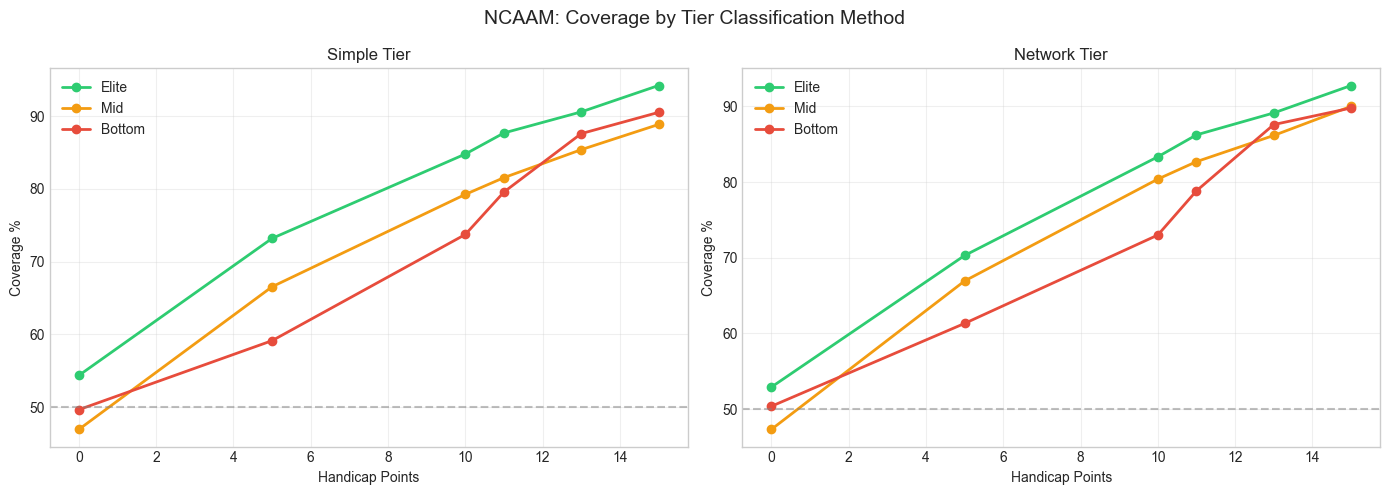

In [16]:
# Plot coverage comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'Elite': '#2ecc71', 'Mid': '#f39c12', 'Bottom': '#e74c3c'}

for idx, tier_type in enumerate(['simple_tier', 'network_tier']):
    ax = axes[idx]
    
    for tier in ['Elite', 'Mid', 'Bottom']:
        data = df_coverage[(df_coverage['tier_type'] == tier_type) & (df_coverage['tier'] == tier)]
        ax.plot(data['handicap'], data['cover_pct'] * 100, 
                marker='o', label=tier, color=colors[tier], linewidth=2)
    
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Handicap Points')
    ax.set_ylabel('Coverage %')
    ax.set_title(f'{tier_type.replace("_", " ").title()}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('NCAAM: Coverage by Tier Classification Method', fontsize=14)
plt.tight_layout()
plt.show()

## Summary & Recommendations

In [17]:
print("="*70)
print("NCAAM NETWORK STRENGTH ANALYSIS: SUMMARY")
print("="*70)

print(f"\n1. DATA")
print(f"   - Games analyzed: {len(df)}")
print(f"   - Teams: {len(all_teams)}")
print(f"   - Network edges: {G.number_of_edges()}")
print(f"   - Graph density: {nx.density(G):.4f}")
print(f"   - Connected components: {len(components)}")

print(f"\n2. NETWORK RATING VALIDATION (teams with 15+ games)")
print(f"   - Correlation with Win%: {corr_win_pct:.3f}")
print(f"   - Correlation with Point Diff: {corr_point_diff:.3f}")
print(f"   - Network SOS vs Simple SOS: {corr_sos:.3f}")

print(f"\n3. TIER CLASSIFICATION")
tier_agreement = (df_compare['simple_tier'] == df_compare['network_tier']).mean() * 100
print(f"   - Agreement rate: {tier_agreement:.1f}%")
print(f"   - Elite disagreements: {len(disagreements)} teams")

print(f"\n4. MULTI-HOP ANALYSIS")
print(f"   - Max hops: {CONFIG['max_hops']}")
print(f"   - Critical for cross-conference comparisons")

print(f"\n5. COVERAGE BY TIER (10pt handicap)")
for tier_type in ['simple_tier', 'network_tier']:
    print(f"   {tier_type.replace('_', ' ').title()}:")
    for tier in ['Elite', 'Mid', 'Bottom']:
        row = df_coverage[(df_coverage['tier_type'] == tier_type) & 
                         (df_coverage['tier'] == tier) &
                         (df_coverage['handicap'] == 10)]
        if len(row) > 0:
            pct = row['cover_pct'].values[0] * 100
            print(f"      {tier}: {pct:.1f}%")

print(f"\n6. NCAAM-SPECIFIC FINDINGS")
print(f"   - Sparse graph requires network analysis for cross-conf comparisons")
print(f"   - Community detection identifies conference-like clusters")
print(f"   - Network rating helps identify overrated/underrated teams")

NCAAM NETWORK STRENGTH ANALYSIS: SUMMARY

1. DATA
   - Games analyzed: 2280
   - Teams: 365
   - Network edges: 2276
   - Graph density: 0.0171
   - Connected components: 1

2. NETWORK RATING VALIDATION (teams with 15+ games)
   - Correlation with Win%: 0.942
   - Correlation with Point Diff: 0.928
   - Network SOS vs Simple SOS: 0.909

3. TIER CLASSIFICATION
   - Agreement rate: 88.6%
   - Elite disagreements: 2 teams

4. MULTI-HOP ANALYSIS
   - Max hops: 3
   - Critical for cross-conference comparisons

5. COVERAGE BY TIER (10pt handicap)
   Simple Tier:
      Elite: 84.8%
      Mid: 79.2%
      Bottom: 73.7%
   Network Tier:
      Elite: 83.3%
      Mid: 80.4%
      Bottom: 73.0%

6. NCAAM-SPECIFIC FINDINGS
   - Sparse graph requires network analysis for cross-conf comparisons
   - Community detection identifies conference-like clusters
   - Network rating helps identify overrated/underrated teams


In [18]:
# Export team data
export_df = df_teams[['team', 'games', 'wins', 'simple_win_pct', 'network_rating', 
                      'point_diff_avg', 'simple_sos', 'network_sos', 'community',
                      'simple_tier', 'network_tier']].copy()

export_file = Path().resolve().parent / 'data' / 'results' / 'ncaam_network_ratings.csv'
export_df.to_csv(export_file, index=False)
print(f"Exported team ratings to: {export_file}")

export_df.head(15)

Exported team ratings to: /Users/robertbatchelor/Documents/Projects/sports-betting/backend/data/results/ncaam_network_ratings.csv


,team,games,wins,simple_win_pct,network_rating,point_diff_avg,simple_sos,network_sos,community,simple_tier,network_tier
126,Michigan Wolverines,13,13,1.000000,1.000000,30.230769,0.642773,0.383227,1,Elite,Elite
250,Arizona Wildcats,14,14,1.000000,0.858987,23.714286,0.525392,0.300919,5,Elite,Elite
9,Purdue Boilermakers,14,13,0.928571,0.824368,19.857143,0.565986,0.350603,3,Elite,Elite
273,Gonzaga Bulldogs,17,16,0.941176,0.815234,24.235294,0.498613,0.314709,5,Elite,Elite
262,Michigan St Spartans,15,13,0.866667,0.809173,14.666667,0.604365,0.363333,2,Elite,Elite
193,Saint Mary's Gaels,14,13,0.928571,0.788784,15.857143,0.549400,0.298974,5,Elite,Elite
341,Iowa State Cyclones,13,13,1.000000,0.785903,26.769231,0.445424,0.279063,0,Elite,Elite
161,UConn Huskies,15,14,0.933333,0.783022,17.666667,0.556752,0.351704,4,Elite,Elite
329,BYU Cougars,14,13,0.928571,0.766563,20.000000,0.583248,0.338551,5,Elite,Elite
24,Vanderbilt Commodores,11,11,1.000000,0.760841,22.636364,0.498654,0.287362,0,Elite,Elite
